In [2]:
import alborex_functions
import alborexdata
import netCDF4
import glob
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap 
import numpy as np
import datetime
from importlib import reload
%matplotlib inline

In [3]:
reload(alborexdata)

<module 'alborexdata' from '/home/ctroupin/Publis/201703_AlborexData/python/alborexdata.py'>

In [4]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# Configuration
Creation of figures

In [5]:
makeFigs, makeFigsLeaflet = 1, 0

Mission:

In [6]:
mission = "alborex"

Create a logger

In [7]:
logger = alborexdata.configure_logging("./logs/alborexFigure2.log")

Domain

In [41]:
if mission == "alborex":
    coordinates = [-6.75, 3.001, 34.75, 40.]
    coordinates2 = [-1, -0.25, 36.65, 37.25]
elif mission == "almo":
    coordinates = [-5.5, 1.3, 34.9, 38.9] 

Create a list of netCDF files containing SST

In [17]:
if mission == "alborex":
    figdir = "../figures/SST/20171007"
    figdir2 = "/home/ctroupin/Projects/Leaflet/AlborEx/images/"
    sstdir = "/home/ctroupin/Data/Alborex/SST/"
elif mission == "almo":
    figdir = "/home/ctroupin/Publis/201702_ALMO/figures/"
    sstdir = "/home/ctroupin/Data/ALMO/SST/"
    figdir2 = "/home/ctroupin/Projects/Leaflet/Missions/ALMO/"

In [18]:
coastfile = "../data/coastline_cartex_f3.txt"
sstfilelist = sorted(glob.glob(os.path.join(sstdir, '*SST*.nc')))
nfiles = len(sstfilelist)
if nfiles == 0:
    logger.warning("No SST files in directory {0}".format(sstdir))
else:
    logger.info("Working on {0} SST files".format(nfiles))

2017-10-07 09:38:08,898 - alborex_logger - INFO - Working on 15 SST files


In [11]:
cmap = plt.cm.RdYlBu_r

# Data reading and plotting

Make figure directory if necessary.

In [12]:
if os.path.isdir(figdir):
    logger.debug("Figure directory {0} already exists".format(figdir))
else:
    os.makedirs(figdir)
    logger.debug("Creating figure directory {0}".format(figdir))
    
if os.path.isdir(figdir2):
    logger.debug("Figure directory {0} already exists".format(figdir))
else:
    os.makedirs(figdir2)
    logger.debug("Creating figure directory {0}".format(figdir))

2017-10-07 09:24:29,533 - alborex_logger - DEBUG - Creating figure directory ../figures/SST/20171007
2017-10-07 09:24:29,534 - alborex_logger - DEBUG - Creating figure directory ../figures/SST/20171007


## Coastline

In [13]:
coastdir = '../data/'
coastfile = os.path.join(coastdir, 'coastline_cartex_f3.txt')

if os.path.exists(coastfile):
    logger.info("{0} exists".format(coastfile))
    loncoast, latcoast = alborexdata.read_lonlat_coast(coastfile)
else:
    logger.warning("{0} does't exist".format(coastfile))  

2017-10-07 09:24:57,807 - alborex_logger - INFO - ../data/coastline_cartex_f3.txt exists


Create the projection (only once)

In [14]:
m = Basemap(projection='merc', llcrnrlon=coordinates[0], llcrnrlat=coordinates[2],
                urcrnrlon=coordinates[1], urcrnrlat=coordinates[3],
                lat_ts=0.5 * (coordinates[2] + coordinates[3]), resolution='h')

## Loop on the files

2017-10-07 10:42:35,541 - alborex_logger - INFO - Working on file: A2014145125000.L2_LAC_SST.nc
2017-10-07 10:42:35,767 - alborex_logger - INFO - Making figure A2014145125000_L2_LAC_SST.png


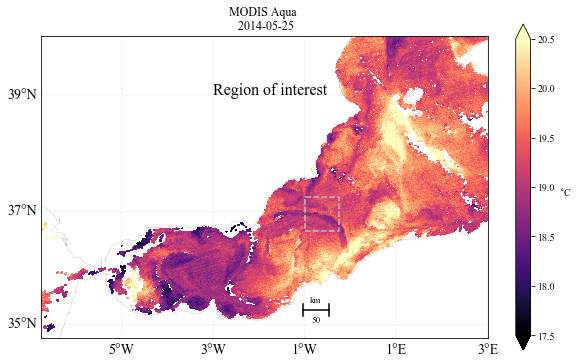

In [64]:
for sstfiles in sstfilelist[0:1]:
    logger.info("Working on file: {0}".format(os.path.basename(sstfiles)))
    
    # Read data from file
    lon, lat, sst, sstqual, year, day, platform = alborex_functions.load_sst_l2(sstfiles)
    
    # Create date from year and day
    titledate = (datetime.datetime(int(year), 1, 1) + datetime.timedelta(int(day) - 1)).strftime('%Y-%m-%d')
    title = ' '.join(('MODIS', platform, '\n', titledate))
    # logger.debug(title)
    
    # Make the SST when flag > 1
    sst = np.ma.masked_where(sstqual > 1, sst)

    # Create figure name (remove .nc extension and substitute . by _)
    figname = ''.join(('_'.join(os.path.basename(sstfiles).split('.')[:-1]), '.png'))
    logger.info("Making figure {0}".format(figname))
    
    if makeFigs:
        # Normal figures
        fig = plt.figure(figsize=(10, 10))
        ax = plt.subplot(111)
        m.ax = ax
        pcm = m.pcolormesh(lon, lat, sst, latlon=True, vmin=17.5, vmax=20.5, cmap=plt.cm.magma)

        # Add the contours
        for i in range(0, len(loncoast)):
            m.plot(np.array(loncoast[i]), np.array(latcoast[i]), color='k', linewidth=.1, latlon=True)

        alborexdata.add_map_grid(m, coordinates, dlon=2., dlat=2.,
                                 fontname='Times New Roman', fontsize=14, 
                                 linewidth=0.2, zorder=1, color=".6")

        #m.fillcontinents(color='w', zorder=2)
        #ax.set_xlim(coordinates[0], coordinates[1])
        #ax.set_ylim(coordinates[2], coordinates[3])

        cb = plt.colorbar(pcm, extend='both', shrink=0.6)
        cb.set_label('$^{\circ}$C', rotation=0, ha='left')
        m.drawmapscale(-.75, 35.25, -1, 35.25, 50)
        m.plot(xrect, yrect, "--", color='.75', latlon=True)

        xtext1, ytext1 = m(-3, 39.)
        xfig1, yfig1 = m(coordinates2[0], coordinates2[2])
        ax.annotate("Region of interest", xy=(xfig1, yfig1), xytext=(xtext1, ytext1),
            xycoords='data', textcoords='data', fontsize=16
            )

        plt.title(title)
        plt.show()
        # plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches='tight',)
        plt.close()
        
    if makeFigsLeaflet:
    
        # Figures without border and axes
        m = Basemap(llcrnrlon=coordinates[0],
                    llcrnrlat=coordinates[2],
                    urcrnrlon=coordinates[1],
                    urcrnrlat=coordinates[3], resolution = 'l', epsg=3857)

        llon, llat = m(lon, lat)
        fig = plt.figure(frameon=False)
        ax = fig.add_axes([0, 0, 1, 1])
        m.pcolormesh(llon, llat, sst, vmin=17., vmax=20., cmap=cmap)
        ax.axis('off')
        #ax.set_xlim(lon.min(), lon.max())
        #ax.set_ylim(lat.min(), lat.max())
        f1 = plt.gca()
        f1.axes.get_xaxis().set_ticks([])
        f1.axes.get_yaxis().set_ticks([])
        plt.savefig(os.path.join(figdir2, figname), transparent=True, 
                    bbox_inches='tight', pad_inches=0)
        plt.close()

In [53]:
xrect = (coordinates2[0], coordinates2[1], coordinates2[1], coordinates2[0], coordinates2[0])
yrect = (coordinates2[2], coordinates2[2], coordinates2[3], coordinates2[3], coordinates2[2])

In [65]:
ax.annotate?